In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, confusion_matrix,r2_score
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from joblib import dump

odi_df_both_innings=pd.read_csv("ODI_Match_Totals.csv")
odi_df=odi_df_both_innings[odi_df_both_innings['Inns']==1]

In [2]:
odi_df.head()

,Unnamed: 0,Score,Overs,RPO,Target,Inns,Result,Opposition,Ground,Start Date,Match_ID,Country,Country_ID
0,412,250,48.3,5.15,NaN,1,won,v India,Kolkata,3 Jan 2013,ODI # 3315,Pakistan,7
3,681,167,43.4,3.82,NaN,1,won,v Pakistan,Delhi,6 Jan 2013,ODI # 3316,India,6
5,1076,305/5,50.0,6.10,NaN,1,won,v Sri Lanka,Melbourne,11 Jan 2013,ODI # 3317,Australia,2
7,836,325/4,50.0,6.50,NaN,1,won,v India,Rajkot,11 Jan 2013,ODI # 3318,England,1
9,1077,170,46.5,3.62,NaN,1,lost,v Sri Lanka,Adelaide,13 Jan 2013,ODI # 3319,Australia,2


In [3]:
odi_df.describe()

,Unnamed: 0,Overs,Target,Inns,Country_ID
count,656.000000,656.000000,0.0,656.0,656.000000
mean,655.582317,47.161585,NaN,1.0,8.772866
std,377.308317,6.980209,NaN,0.0,10.593182
min,1.000000,1.000000,NaN,1.0,1.000000
25%,323.750000,49.000000,NaN,1.0,3.000000
50%,645.500000,50.000000,NaN,1.0,5.000000
75%,995.250000,50.000000,NaN,1.0,8.000000
max,1294.000000,50.000000,NaN,1.0,40.000000


In [4]:
odi_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 656 entries, 0 to 1295
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  656 non-null    int64  
 1   Score       656 non-null    object 
 2   Overs       656 non-null    float64
 3   RPO         656 non-null    object 
 4   Target      0 non-null      float64
 5   Inns        656 non-null    int64  
 6   Result      656 non-null    object 
 7   Opposition  656 non-null    object 
 8   Ground      656 non-null    object 
 9   Start Date  656 non-null    object 
 10  Match_ID    656 non-null    object 
 11  Country     656 non-null    object 
 12  Country_ID  656 non-null    int64  
dtypes: float64(2), int64(3), object(8)
memory usage: 71.8+ KB


In [5]:
odi_df.nunique()

Unnamed: 0    656
Score         499
Overs          99
RPO           290
Target          0
Inns            1
Result          5
Opposition     16
Ground         94
Start Date    572
Match_ID      656
Country        10
Country_ID     10
dtype: int64

In [6]:
odi_df.dtypes

Unnamed: 0      int64
Score          object
Overs         float64
RPO            object
Target        float64
Inns            int64
Result         object
Opposition     object
Ground         object
Start Date     object
Match_ID       object
Country        object
Country_ID      int64
dtype: object

In [7]:
odi_df.columns

Index(['Unnamed: 0', 'Score', 'Overs', 'RPO', 'Target', 'Inns', 'Result',
       'Opposition', 'Ground', 'Start Date', 'Match_ID', 'Country',
       'Country_ID'],
      dtype='object')

In [8]:
odi_df['RPO'].replace('-','0',inplace=True)
odi_df['Country'].replace('Newzealad','Newzealand',inplace=True)

C:\Users\parth\AppData\Local\Temp\ipykernel_2304\318875144.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  odi_df['RPO'].replace('-','0',inplace=True)
C:\Users\parth\AppData\Local\Temp\ipykernel_2304\318875144.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  odi_df['Country'].replace('Newzealad','Newzealand',inplace=True)


In [9]:
def extract_runs(score):
    return int(score.split('/')[0])
def extract_wickets(score):
    return int(score.split('/')[1])
def change(score):
    if '/' not in score:
        return score+'/10'
    else:
        return score
def alter(Opposition):
    return Opposition.split()[1]
def is_dnb_present(scores):
    return 'DNB' in scores.values

def matchid(mid):
    return mid.split()[-1]
#Dropping matches with n/r
odi_df=odi_df[odi_df['Result'].isin(['won','lost'])]
match_ids_to_drop = odi_df.groupby('Match_ID')['Score'].filter(is_dnb_present).index
odi_df = odi_df.drop(match_ids_to_drop)
odi_df['Score']=odi_df['Score'].apply(change)
odi_df['Runs']=odi_df['Score'].apply(extract_runs)
odi_df['Wickets']=odi_df['Score'].apply(extract_wickets)
odi_df['Opposition']=odi_df['Opposition'].apply(alter)
odi_df['Match_ID']=odi_df['Match_ID'].apply(matchid)
odi_df.rename(columns={'Country': 'bat_team', 'Opposition': 'bowl_team'}, inplace=True)
odi_df['total']=odi_df['Runs']
odi_df.head(5)

,Unnamed: 0,Score,Overs,RPO,Target,Inns,Result,bowl_team,Ground,Start Date,Match_ID,bat_team,Country_ID,Runs,Wickets,total
0,412,250/10,48.3,5.15,NaN,1,won,India,Kolkata,3 Jan 2013,3315,Pakistan,7,250,10,250
3,681,167/10,43.4,3.82,NaN,1,won,Pakistan,Delhi,6 Jan 2013,3316,India,6,167,10,167
5,1076,305/5,50.0,6.10,NaN,1,won,Sri,Melbourne,11 Jan 2013,3317,Australia,2,305,5,305
7,836,325/4,50.0,6.50,NaN,1,won,India,Rajkot,11 Jan 2013,3318,England,1,325,4,325
9,1077,170/10,46.5,3.62,NaN,1,lost,Sri,Adelaide,13 Jan 2013,3319,Australia,2,170,10,170


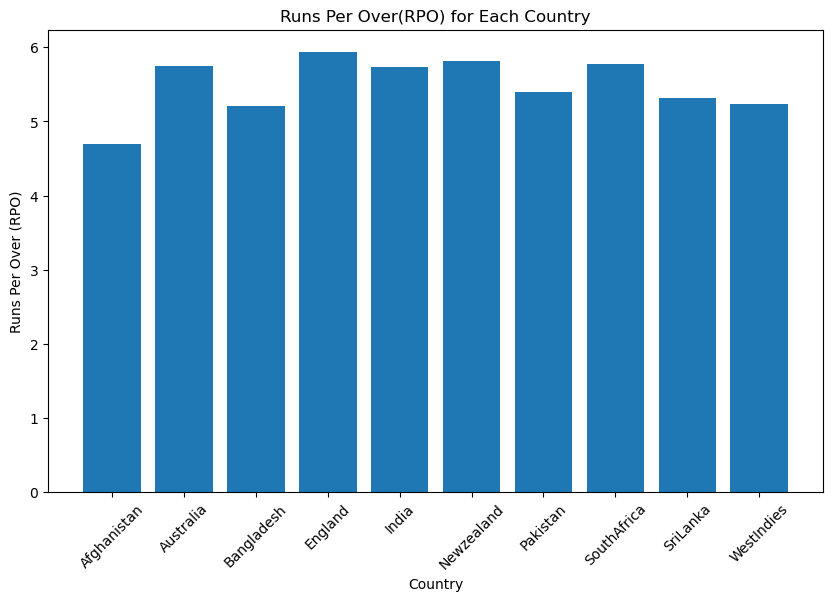

In [10]:
#RPO for every Country
odi_df['RPO'] = pd.to_numeric(odi_df['RPO'], errors='coerce')
grouped_data = odi_df.groupby('bat_team')['RPO'].mean()
grouped_df = grouped_data.reset_index()
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(grouped_df['bat_team'], grouped_df['RPO'])
ax.set_xlabel('Country')
ax.set_ylabel('Runs Per Over (RPO)')
ax.set_title('Runs Per Over(RPO) for Each Country')
plt.xticks(rotation = 45)
plt.show()

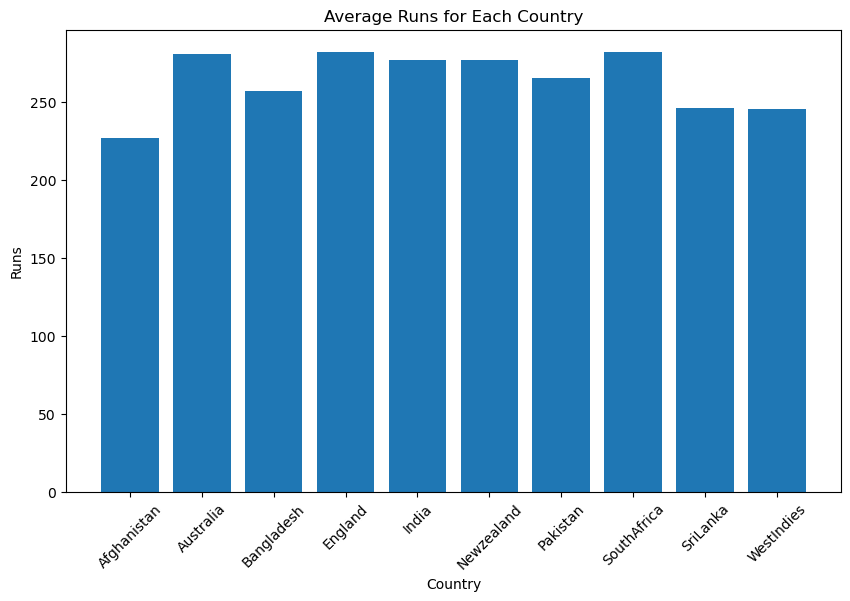

In [11]:
#Runs Scored by every Country
grouped_data = odi_df.groupby('bat_team')['Runs'].mean()
grouped_df = grouped_data.reset_index()
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(grouped_df['bat_team'], grouped_df['Runs'])
ax.set_xlabel('Country')
ax.set_ylabel('Runs')
ax.set_title('Average Runs for Each Country')
plt.xticks(rotation = 45)
plt.show()

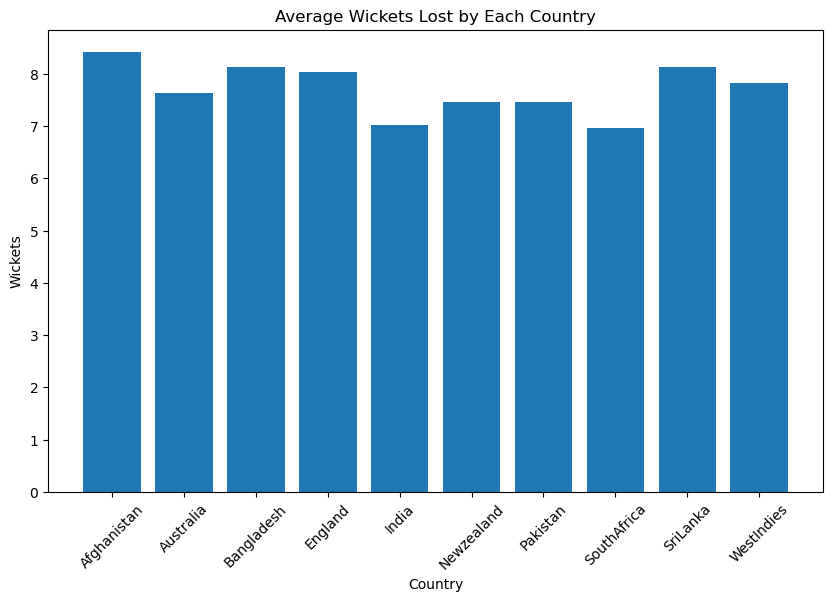

In [12]:
grouped_data = odi_df.groupby('bat_team')['Wickets'].mean()
grouped_df = grouped_data.reset_index()
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(grouped_df['bat_team'], grouped_df['Wickets'])
ax.set_xlabel('Country')
ax.set_ylabel('Wickets')
ax.set_title('Average Wickets Lost by Each Country')
plt.xticks(rotation = 45)
plt.show()

In [13]:
#Dropping Useless Columns
irrelevant=['Unnamed: 0','Ground','Start Date','Country_ID','Score','RPO','Target','Inns','Match_ID','total']

odi_df=odi_df.drop(columns=irrelevant,axis=1)
odi_df.head()


,Overs,Result,bowl_team,bat_team,Runs,Wickets
0,48.3,won,India,Pakistan,250,10
3,43.4,won,Pakistan,India,167,10
5,50.0,won,Sri,Australia,305,5
7,50.0,won,India,England,325,4
9,46.5,lost,Sri,Australia,170,10


C:\Users\parth\AppData\Local\Temp\ipykernel_2304\3628611605.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix=odi_df.corr()


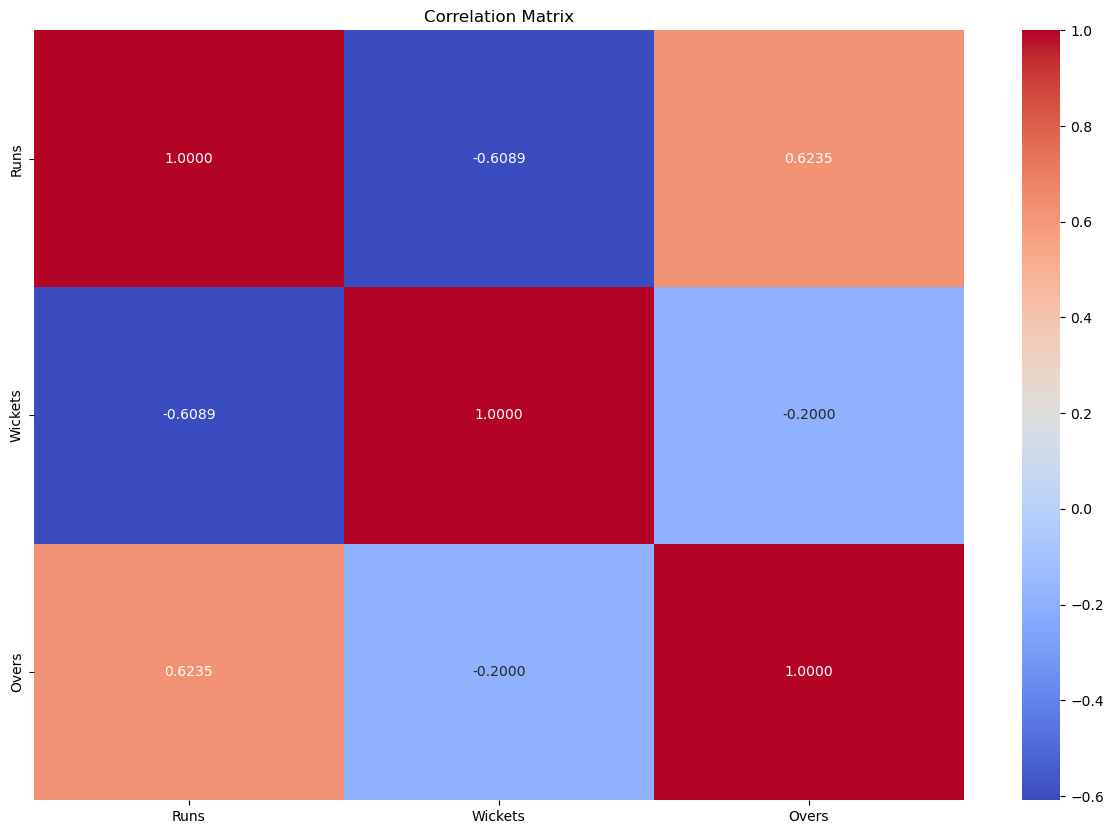

In [14]:
#Plotting Correlation Matrix
alternate_order=['bat_team','bowl_team','Runs','Wickets','Overs','Result']
odi_df=odi_df[alternate_order]
corr_matrix=odi_df.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix,cmap='coolwarm', annot=True, fmt=".4f")
plt.title('Correlation Matrix')
plt.show()

In [15]:
odi_df['Result'] = odi_df['Result'].map({'won': 1, 'lost': 0})

odi_df.head(50)


,bat_team,bowl_team,Runs,Wickets,Overs,Result
0,Pakistan,India,250,10,48.3,1
3,India,Pakistan,167,10,43.4,1
5,Australia,Sri,305,5,50.0,1
7,England,India,325,4,50.0,1
9,Australia,Sri,170,10,46.5,0
10,India,England,285,6,50.0,1
13,Australia,Sri,74,10,26.4,0
15,England,India,155,10,42.2,0
16,SouthAfrica,New,208,10,46.2,0
21,Newzealand,South,279,8,50.0,1


In [16]:
# Encoding categorical features
label_encoder = LabelEncoder()
odi_df['bat_team'] = label_encoder.fit_transform(odi_df['bat_team'])
odi_df['bowl_team'] = label_encoder.fit_transform(odi_df['bowl_team'])

# Feature selection
X = odi_df[['Runs', 'Wickets', 'Overs', 'bat_team', 'bowl_team']]
y = odi_df['Result']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)


In [17]:
# Use one-hot encoding for categorical features
column_transformer = ColumnTransformer(
    transformers=[('encoder', OneHotEncoder(), ['bat_team', 'bowl_team'])],
    remainder='passthrough'
)

X_encoded = column_transformer.fit_transform(X_train)



In [18]:
# Train a Support Vector Classifier (SVC)
svc_classifier = SVC(probability=True, random_state=42)
svc_classifier.fit(X_encoded, y_train)

def predict_win_probability_svc(runs, wickets, overs, bat_team, bowl_team):
    # Encode categorical features
    bat_team_encoded = label_encoder.transform([bat_team])[0]
    bowl_team_encoded = label_encoder.transform([bowl_team])[0]

    # Create a DataFrame with the input data
    input_data = pd.DataFrame({
        'Runs': [runs],
        'Wickets': [wickets],
        'Overs': [overs],
        'bat_team': [bat_team_encoded],
        'bowl_team': [bowl_team_encoded]
    })

    # Use one-hot encoding for categorical features
    input_data_encoded = column_transformer.transform(input_data)

    # Make predictions
    win_probability = svc_classifier.predict_proba(input_data_encoded)[:, 1][0]

    return win_probability

In [19]:
# Test Case 1
runs_input = 240
wickets_input = 9
overs_input = 50
bat_team_input = 'India'
bowl_team_input = 'Australia'


win_percentage_svc= predict_win_probability_svc(runs_input, wickets_input, overs_input, bat_team_input, bowl_team_input)
print(f'Predicted Win Percentage (SVC): {win_percentage_svc * 100:.2f}%')
print('Winner-Australia')

Predicted Win Percentage (SVC): 43.25%
Winner-Australia


In [20]:
# Test Case 2
runs_input = 199
wickets_input = 10
overs_input = 49.3
bat_team_input = 'Australia'
bowl_team_input = 'India'

win_percentage_svc = predict_win_probability_svc(runs_input, wickets_input, overs_input, bat_team_input, bowl_team_input)
print(f'Predicted Win Percentage (SVC): {win_percentage_svc * 100:.2f}%')
print('Winner-India')

Predicted Win Percentage (SVC): 22.60%
Winner-India


In [21]:
# Test Case 3
runs_input = 112
wickets_input = 5
overs_input = 18.2
bat_team_input = 'Afghanistan'
bowl_team_input = 'India'

win_percentage_svc = predict_win_probability_svc(runs_input, wickets_input, overs_input, bat_team_input, bowl_team_input)
print(f'Predicted Win Percentage (SVC): {win_percentage_svc * 100:.2f}%')
print('Winner-India')

Predicted Win Percentage (SVC): 6.15%
Winner-India


In [22]:
# Test Case 4
runs_input = 191
wickets_input = 10
overs_input = 42.5
bat_team_input = 'Pakistan'
bowl_team_input = 'India'

win_percentage_svc = predict_win_probability_svc(runs_input, wickets_input, overs_input, bat_team_input, bowl_team_input)
print(f'Predicted Win Percentage (SVC): {win_percentage_svc * 100:.2f}%')
print('Winner-India')

Predicted Win Percentage (SVC): 19.88%
Winner-India


In [23]:
# Test Case 5
runs_input = 256
wickets_input = 8
overs_input = 50
bat_team_input = 'Bangladesh'
bowl_team_input = 'India'

win_percentage_svc = predict_win_probability_svc(runs_input, wickets_input, overs_input, bat_team_input, bowl_team_input)
print(f'Predicted Win Percentage (SVC): {win_percentage_svc * 100:.2f}%')
print('Winner-India')

Predicted Win Percentage (SVC): 52.33%
Winner-India


In [24]:
# Test Case 6
runs_input = 229
wickets_input = 9
overs_input = 50
bat_team_input = 'India'
bowl_team_input = 'England'

win_percentage_svc = predict_win_probability_svc(runs_input, wickets_input, overs_input, bat_team_input, bowl_team_input)
print(f'Predicted Win Percentage (SVC): {win_percentage_svc * 100:.2f}%')
print('Winner-India')

Predicted Win Percentage (SVC): 37.22%
Winner-India


In [25]:
# Test Case 7
runs_input = 356
wickets_input =2
overs_input = 50
bat_team_input = 'India'
bowl_team_input = 'Pakistan'

win_percentage_svc = predict_win_probability_svc(runs_input, wickets_input, overs_input, bat_team_input, bowl_team_input)
print(f'Predicted Win Percentage (SVC): {win_percentage_svc * 100:.2f}%')
print('Winner-India')

Predicted Win Percentage (SVC): 84.31%
Winner-India


In [26]:
# Test Case 8
runs_input = 269
wickets_input = 10
overs_input = 49
bat_team_input = 'Australia'
bowl_team_input = 'India'

win_percentage_svc = predict_win_probability_svc(runs_input, wickets_input, overs_input, bat_team_input, bowl_team_input)
print(f'Predicted Win Percentage (SVC): {win_percentage_svc * 100:.2f}%')
print('Winner-Australia')

Predicted Win Percentage (SVC): 59.26%
Winner-Australia


In [27]:
# Test Case 9
runs_input = 265
wickets_input = 8
overs_input = 50
bat_team_input = 'Bangladesh'
bowl_team_input = 'India'

win_percentage_svc = predict_win_probability_svc(runs_input, wickets_input, overs_input, bat_team_input, bowl_team_input)
print(f'Predicted Win Percentage (SVC): {win_percentage_svc * 100:.2f}%')
print('Winner-India')

Predicted Win Percentage (SVC): 57.22%
Winner-India


In [28]:
# Test Case 10
runs_input = 117
wickets_input = 10
overs_input = 26
bat_team_input = 'India'
bowl_team_input = 'Australia'

win_percentage_svc = predict_win_probability_svc(runs_input, wickets_input, overs_input, bat_team_input, bowl_team_input)
print(f'Predicted Win Percentage (SVC): {win_percentage_svc * 100:.2f}%')
print('Winner-Australia')

Predicted Win Percentage (SVC): 6.27%
Winner-Australia


In [29]:
import pickle
filename = "ml_model.pkl"
pickle.dump(svc_classifier, open(filename, "wb"))

In [30]:
dump(column_transformer, 'column_transformer.joblib')
dump(label_encoder, 'label_encoder.joblib')

['label_encoder.joblib']